<a href="https://colab.research.google.com/github/angadbajwa23/Brain-Image-Segmentation/blob/master/Data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd gdrive/My Drive/2d

/content/gdrive/My Drive/2d


### Downloading the dataset from [figshare.com/articles/brain_tumor_dataset/1512427](figshare.com/articles/brain_tumor_dataset/1512427)



In [0]:
!wget https://ndownloader.figshare.com/articles/1512427/versions/5

--2020-05-18 06:28:44--  https://ndownloader.figshare.com/articles/1512427/versions/5
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 34.251.18.86, 34.240.222.171, 34.252.153.30, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|34.251.18.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 879501695 (839M) [application/zip]
Saving to: ‘5’

5                   100%[===================>] 838.76M  23.7MB/s    in 38s     

2020-05-18 06:29:22 (22.2 MB/s) - ‘5’ saved [879501695/879501695]



In [0]:
!unzip 5 && rm 5

Archive:  5
 extracting: brainTumorDataPublic_1-766.zip  
 extracting: brainTumorDataPublic_1533-2298.zip  
 extracting: brainTumorDataPublic_767-1532.zip  
 extracting: brainTumorDataPublic_2299-3064.zip  
 extracting: cvind.mat               
 extracting: README.txt              


In [0]:
!cat brainTumorDataPublic_* > brainTumorDataPublic_temp.zip
!zip -FF brainTumorDataPublic_temp.zip --out data.zip

In [0]:
!rm brainTumorDataPublic_*

In [0]:
!unzip data.zip -d data && rm data.zip

In [0]:
!ls data | wc -l

3064


In [4]:
!pip install hdf5storage

     |████████████████████████████████| 61kB 1.7MB/s 


### Creating images, labels and masks numpy arrays 

In [5]:
import os
import argparse
import sys
import numpy as np
import hdf5storage
import cv2
import matplotlib.pyplot as plt

class NoDataFound(Exception):
    pass


def dir_path(path):
    """Check the path and the existence of a data directory"""
    # replace '\' in path for Windows users
    path = path.replace('\\', '/')
    data_path = os.path.join(path, 'data').replace('\\', '/')

    if os.path.isdir(data_path):
        return path
    elif os.path.isdir(path):
        raise NoDataFound('Could not find a "data" folder inside directory. {} does not exist.'
                          .format(data_path))
    else:
        raise NotADirectoryError(path)

path='/content/gdrive/My Drive/2d/'
parser = argparse.ArgumentParser()
parser.add_argument('path', help='path to the brain_tumor_dataset directory', type=dir_path)
parser.add_argument('--image-dimension', '-d', default=512, help='dimension of the image', type=int)
args = parser.parse_args(args=[path])

labels = []
images = []
masks = []

data_dir = os.path.join(args.path, 'data').replace('\\', '/')
files = os.listdir(data_dir)
for i, file in enumerate(files, start=1):
    if i % 10 == 0:
        # print the percentage of images loaded
        sys.stdout.write('\r[{}/{}] images loaded: {:.1f} %'
                         .format(i, len(files), i / float(len(files)) * 100))
        sys.stdout.flush()

    # load matlab file with hdf5storage as scipy.io.loadmat does not support v7.3 files
    mat_file = hdf5storage.loadmat(os.path.join(data_dir, file))['cjdata'][0]

    # resize image and mask to a unique size
    image = cv2.resize(mat_file[2], dsize=(args.image_dimension, args.image_dimension),
                       interpolation=cv2.INTER_CUBIC)
    mask = cv2.resize(mat_file[4].astype('uint8'), dsize=(args.image_dimension, args.image_dimension),
                      interpolation=cv2.INTER_CUBIC)

    labels.append(int(mat_file[0]))
    images.append(image)
    masks.append(mask.astype(bool))

sys.stdout.write('\r[{}/{}] images loaded: {:.1f} %'
                 .format(i, len(files), i / float(len(files)) * 100))
sys.stdout.flush()

labels = np.array(labels)
images = np.array(images)
masks = np.array(masks)

print('\nlabels:', labels.shape)
print('images:', images.shape)
print('masks:', masks.shape)

np.save(os.path.join(args.path, 'labels.npy'), labels)
np.save(os.path.join(args.path, 'images.npy'), images)
np.save(os.path.join(args.path, 'masks.npy'), masks)

print('labels.npy, images.npy, masks.npy saved in', args.path)

[3064/3064] images loaded: 100.0 %
labels: (3064,)
images: (3064, 512, 512)
masks: (3064, 512, 512)
labels.npy, images.npy, masks.npy saved in /content/gdrive/My Drive/2d/


In [0]:
integer_to_class = {'1': 'meningioma (1)', '2': 'glioma (2)', '3': 'pituitary tumor (3)'}

In [8]:
labels = np.load('labels.npy')
images = np.load('images.npy')
masks = np.load('masks.npy')

print(labels.shape)
print(images.shape)
print(masks.shape)

(3064,)
(3064, 512, 512)
(3064, 512, 512)


### Data Visualizations

number of meningioma (1): 708
number of glioma (2): 1426
number of pituitary tumor (3): 930


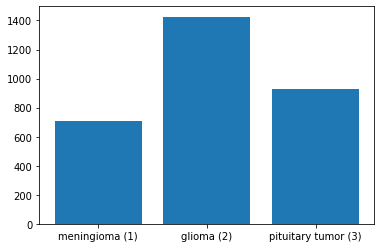

In [0]:
classes, counts = np.unique(labels, return_counts=True)
plt.bar(classes, counts, 
        tick_label=['meningioma (1)', 'glioma (2)', 'pituitary tumor (3)'])

for i, idx in enumerate(classes):
    print('number of {}: {}'.format(integer_to_class[str(idx)], counts[i]))

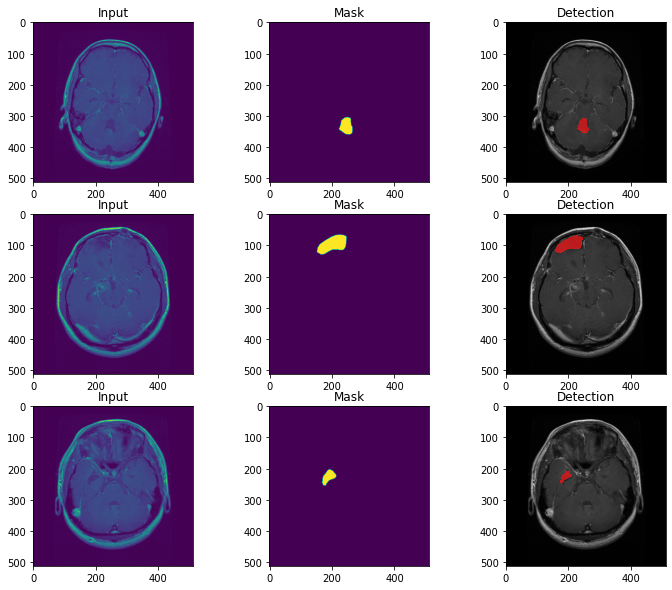

In [31]:
plt.figure(figsize=(12, 10))

plt.subplot(3,3,1)
plt.title('Input')
plt.imshow(images[0,:])

plt.subplot(3,3,2)
plt.title('Mask')
plt.imshow(masks[0,:])

plt.subplot(3,3,3)
plt.title('Detection')
plt.imshow(images[0,:],cmap='gray')
mask = np.ma.masked_where(masks[0] == False, masks[0])
plt.imshow(mask, alpha=0.8, cmap='Set1')
  
plt.subplot(3,3,4)
plt.title('Input')
plt.imshow(images[1,:])

plt.subplot(3,3,5)
plt.title('Mask')
plt.imshow(masks[1,:])

plt.subplot(3,3,6)
plt.title('Detection')
plt.imshow(images[1,:],cmap='gray')
mask = np.ma.masked_where(masks[1] == False, masks[1])
plt.imshow(mask, alpha=0.8, cmap='Set1')

plt.subplot(3,3,7)
plt.title('Input')
plt.imshow(images[2,:])

plt.subplot(3,3,8)
plt.title('Mask')
plt.imshow(masks[2,:])

plt.subplot(3,3,9)
plt.title('Detection')
plt.imshow(images[2,:],cmap='gray')
mask = np.ma.masked_where(masks[2] == False, masks[2])
plt.imshow(mask, alpha=0.8, cmap='Set1')
  
  


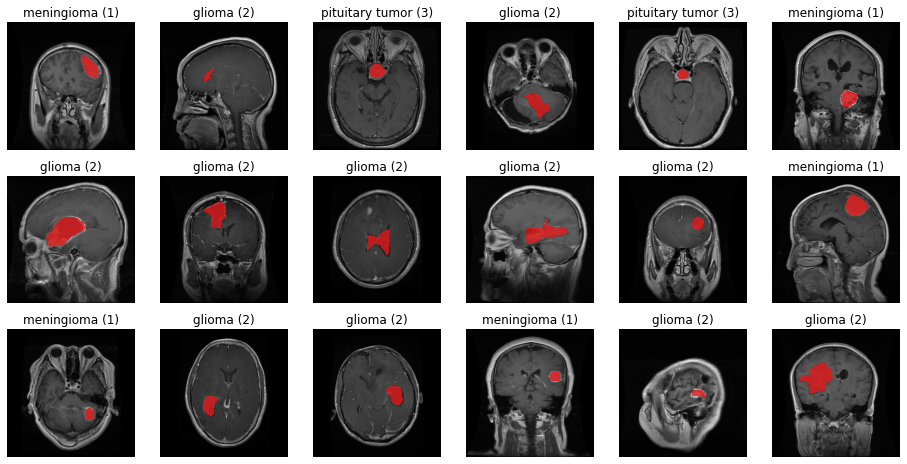

In [22]:
plt.figure(figsize=(16, 8))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow(images[idx], cmap='gray')
    
    # set black pixel as transparent for the mask
    mask = np.ma.masked_where(masks[idx] == False, masks[idx])
    plt.imshow(mask, alpha=0.8, cmap='Set1')
    
    plt.title(integer_to_class[str(labels[idx])])
    plt.axis('off')

## Cropping Images

In [0]:
def get_bounding_box(mask):
    """
    Return the bounding box of a mask image.
    """
    xmin, ymin, xmax, ymax = 0, 0, 0, 0

    for row in range(mask.shape[0]):
        if mask[row, :].max() != 0:
            ymin = row
            break

    for row in range(mask.shape[0] - 1, -1, -1):
        if mask[row, :].max() != 0:
            ymax = row
            break

    for col in range(mask.shape[1]):
        if mask[:, col].max() != 0:
            xmin = col
            break

    for col in range(mask.shape[1] - 1, -1, -1):
        if mask[:, col].max() != 0:
            xmax = col
            break

    return xmin, ymin, xmax, ymax


def crop_to_bbox(image, bbox, crop_margin=10):
    """
    Crop an image to the bounding by forcing a squared image as output.
    """
    x1, y1, x2, y2 =  bbox
    
    # force a squared image
    max_width_height = np.maximum(y2 - y1, x2 - x1)
    y2 = y1 + max_width_height
    x2 = x1 + max_width_height

    # in case coordinates are out of image boundaries
    y1 = np.maximum(y1 - crop_margin, 0)
    y2 = np.minimum(y2 + crop_margin, image.shape[0])
    x1 = np.maximum(x1 - crop_margin, 0)
    x2 = np.minimum(x2 + crop_margin, image.shape[1])
    
    return image[y1:y2, x1:x2]

In [35]:
from IPython.display import display, clear_output

dim_cropped_image = 224

images_cropped = []

for i in range(images.shape[0]):
    if i % 10 == 0:
        # print the pecentage of images processed
        clear_output(wait=True)
        display('[{}/{}] images processed: {:.1f} %'
                .format(i+1, images.shape[0], (i+1) / images.shape[0] * 100))
        
    bbox = get_bounding_box(masks[i])
    image = crop_to_bbox(images[i], bbox, 20)
    image = cv2.resize(image, dsize=(dim_cropped_image, dim_cropped_image),
                       interpolation=cv2.INTER_CUBIC)
    images_cropped.append(image)
    
clear_output(wait=True)
display('[{}/{}] images processed: {:.1f} %'
        .format(i+1, images.shape[0], (i+1) / images.shape[0] * 100))

'[3064/3064] images processed: 100.0 %'

In [36]:
images_cropped = np.array(images_cropped)

print(images_cropped.shape)

(3064, 224, 224)


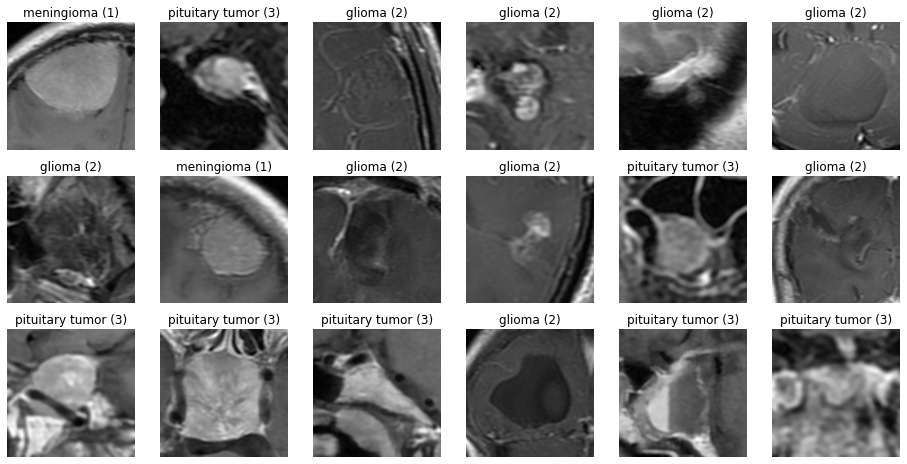

In [38]:
plt.figure(figsize=(16, 8))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow(images_cropped[idx],cmap='gray')
  
    plt.title(integer_to_class[str(labels[idx])])
    plt.axis('off')